# Use PyMC Model for Bayes Hierarchical RL
- Estimate learning rate (i.e. alpha) for each subject using this model

In [1]:
%config Completer.use_jedi = False

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import os
# import stan

import pymc as pm
import pymc.sampling_jax
import arviz as az

import aesara.tensor as at # used by PyMC 4.0
import aesara
# import learning package
#import DMpy

/gpfs/ysm/project/joormann/oad4/conda_envs/pymc4/lib/python3.9/site-packages/aesara/link/jax/dispatch.py:87: UserWarning: JAX omnistaging couldn't be disabled: Disabling of omnistaging is no longer supported in JAX version 0.2.12 and higher: see https://github.com/google/jax/blob/main/design_notes/omnistaging.md.
  warnings.warn(f"JAX omnistaging couldn't be disabled: {e}")
/gpfs/ysm/project/joormann/oad4/conda_envs/pymc4/lib/python3.9/site-packages/pymc/sampling_jax.py:36: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


In [2]:
# read scr file
#scr = pd.read_csv('/media/Data/Lab_Projects/PTSD_Reversal/Behavioral/SCR3.csv')
scr = pd.read_csv('Behavioral/SCR3.csv')
scr.head()



,Event.Nr,CDA.nSCR,CDA.Latency,CDA.AmpSum,CDA.SCR,CDA.ISCR,CDA.PhasicMax,CDA.Tonic,TTP.nSCR,TTP.Latency,TTP.AmpSum,Global.Mean,Global.MaxDeflection,Event.NID,Event.Name,Condition,group,sub
0,1,5,0.8435,0.2852,0.0003,0.1339,8.1296,2.3324,1,3.9335,0.5884,2.4822,0.5884,5,5,CSplusUS1,HC,189
1,2,4,0.7335,0.1033,0.0012,0.4737,0.3046,4.0029,0,NaN,0.0000,4.3933,0.0000,5,5,CSminus1,HC,189
2,3,3,2.9835,0.0783,0.0008,0.3237,0.1352,3.9579,1,2.8335,0.0260,3.9900,0.0154,5,5,CSplus1,HC,189
3,4,1,3.4935,0.1772,0.0002,0.0993,7.0748,3.8756,1,3.5335,0.5186,3.9212,0.5186,5,5,CSplusUS1,HC,189
4,5,0,NaN,0.0000,0.0004,0.1532,0.1604,4.2513,0,NaN,0.0000,4.3461,0.0000,5,5,CSminus1,HC,189


In [3]:
scr = scr[['sub','Condition','Event.Nr','CDA.AmpSum']]
scr['sub'] = scr['sub'].astype('string')
for i in scr.iterrows():
    if len(i[1]['sub'])<=2:
        #print(i[1]['sub'])
        sub = 'sub-0' + str(i[1]['sub'])
    else:
        sub = 'sub-' + str(i[1]['sub'])
    #print(sub)
    scr.at[i[0], 'sub'] = sub
    

In [4]:
len(scr['sub'].unique())

101

In [6]:
# grab subjects with 69 trials
scr_clean = scr.copy() # make a copy of original
for sub in scr['sub'].unique():
    df = scr[scr['sub']==sub]
    #print (len(df))
    if len(df)<69:
        scr_clean = scr_clean[scr_clean['sub']!=sub]
        
len(scr_clean['sub'].unique()) # total of 86 valid subjects


86

In [7]:
# list of subjects that has both fMRI and SCR data
subject_list = ['sub-189', 'sub-205', 'sub-071', 'sub-204', 'sub-085', 'sub-100', 'sub-132', 'sub-185', 'sub-167', 'sub-043', 'sub-062', 'sub-073',
       'sub-082', 'sub-030', 'sub-160', 'sub-196', 'sub-1223', 'sub-169', 'sub-1222', 'sub-055', 'sub-170', 'sub-047', 'sub-177', 'sub-130',
       'sub-172', 'sub-200', 'sub-173', 'sub-026', 'sub-059', 'sub-072', 'sub-1232', 'sub-166', 'sub-032', 'sub-016', 'sub-1205', 'sub-186',
       'sub-056', 'sub-053', 'sub-150', 'sub-065', 'sub-154', 'sub-193', 'sub-165', 'sub-103', 'sub-168', 'sub-102', 'sub-048', 'sub-027',
       'sub-182', 'sub-202', 'sub-203', 'sub-066', 'sub-038', 'sub-184', 'sub-171', 'sub-179', 'sub-153', 'sub-144', 'sub-178', 'sub-063',
       'sub-010', 'sub-158', 'sub-083', 'sub-126', 'sub-152']


In [8]:
# grab only relevant subjects (with both MRI and SCR data)
scrTwo = scr_clean[scr_clean['sub'].isin(subject_list)]#[(scr['sub']==152) |(scr['sub']==189) | (scr['sub']==86) | (scr['sub']==48)]
scrTwo['Event.Nr'].values

array([ 1,  2,  3, ..., 67, 68, 69])

Organize the data for the analysis

In [9]:
# organize data accordingly
# first, grab just the relevant variables (subject, trial, stimuli, shock)
# we need to generate a new variable shock (1=yes, 0=no)
# we also need a new variable stim (1=CS+, 2=CS-)
scrVec = scrTwo['CDA.AmpSum'].values
print(scrVec.shape)
shockVec = np.zeros(len(scrVec), dtype=np.int32) # vector to capture shock (1=yes, 0=no)
stimVec = np.zeros(len(scrVec), dtype=np.int32) # vector to capture stimulus (1=CS+, 2= CS-)

for i, cond in enumerate(scrTwo['Condition'].values):
    if cond=='CSplusUS1':
        shockVec[i]= 1
        stimVec[i] = 1
    elif cond=='CSminusUS2':
            # after reversal so minus becomes plus
        shockVec[i]= 1
        stimVec[i] = 0
    elif cond=='CSplus2':
            # after reversal so plus becomes minus
            shockVec[i]=0
            stimVec[i] = 1
    elif cond=='CSplus1':
            stimVec[i] = 1
            shockVec[i]= 0
    elif cond=='CSminus1':
            stimVec[i] = 0
            shockVec[i] = 0
    elif cond=='CSminus2':
        stimVec[i] = 0
        shockVec[i] = 0
    else:
        print(f' Condition is {cond}')
        stimVec[i] = 9
        shockVec[i] = 9
print(shockVec.shape)
print(stimVec.shape)

(4485,)
(4485,)
(4485,)


In [10]:
sum(shockVec) / sum(stimVec) 

0.38235294117647056

In [11]:
n_trials, n_subj = 69,len(scrTwo['sub'].unique())
trials, subj = np.meshgrid(range(n_trials), range(n_subj))

In [12]:
n_trials, n_subj = 69,len(scrTwo['sub'].unique())
trials, subj = np.meshgrid(range(n_trials), range(n_subj))

trials = at.as_tensor_variable(trials.T)
subj = at.as_tensor_variable(subj.T)
stim = np.reshape(stimVec, (n_subj,n_trials)).T # transform to matrix trials x subject
shock = np.reshape(shockVec, (n_subj,n_trials)).T 
scrMat = np.reshape(scrVec, (n_subj, n_trials)).T

In [13]:
stim = at.as_tensor_variable(stim)
shock = at.as_tensor_variable(shock)


# Build PyMC code

In [14]:
#scrs = tt.zeros(30) # set empty scr tensor (vector)
   
# generate functions to run
def update_Q(stim, shock,
             Qs,vec,
             alpha, n_subj):
    """
    This function updates the Q table according to the RL update rule.
    It will be called by theano.scan to do so recursevely, given the observed data and the alpha parameter
    This could have been replaced be the following lamba expression in the theano.scan fn argument:
        fn=lamba action, reward, Qs, alpha: tt.set_subtensor(Qs[action], Qs[action] + alpha * (reward - Qs[action]))
    """
      
    PE = shock - Qs[at.arange(n_subj), stim]
    Qs = at.set_subtensor(Qs[at.arange(n_subj),stim], Qs[at.arange(n_subj),stim] + alpha * PE)
    
    # in order to get a vector of expected outcome (dependent on the stimulus presentes [CS+, CS-] 
    # we us if statement (switch in theano)
    vec = at.set_subtensor(vec[at.arange(n_subj),0], (at.switch(at.eq(stim,1), 
                                                                Qs[at.arange(n_subj),1], Qs[at.arange(n_subj),0])))
    
    return Qs, vec, PE

def theano_llik_td(alpha,  stim, shock, n_subj):
   # stim = theano.shared(np.asarray(stim, dtype='int16'))
   # shock = theano.shared(np.asarray(shock, dtype='int16'))

    # Compute the Qs values
    Qs = 0.5 * at.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec = 0.5 * at.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    [Qs,vec, PE], updates = aesara.scan(
        fn=update_Q,
        sequences=[stim, shock],
        outputs_info=[Qs, vec, None],
        non_sequences=[alpha, n_subj])

       
    return Qs, vec, PE

In [19]:
results, vec, pe = theano_llik_td(0.2, stim, shock, n_subj)
vec_ = vec[trials, subj,0]
v = at.reshape(vec_.T, n_subj*n_trials, ndim=1)
vec_clean = v[shockVec==0]

In [21]:
vec_clean.eval()

array([0.4       , 0.48      , 0.32      , ..., 0.22667535, 0.00543432,
       0.18134028])

In [16]:
# get index
shIn = np.argwhere(shockVec==1)
# remove shocks from SCR vector (feed the model)
scrV = np.reshape(scrMat.T, n_subj*n_trials)
# clean scr from shocks
scrClean = scrVec[shockVec==0]#np.delete(scrVec, shIn)

In [23]:
scrClean.shape

(3640,)

In [32]:
np.min(scrClean)

0.0

<AxesSubplot:ylabel='Count'>

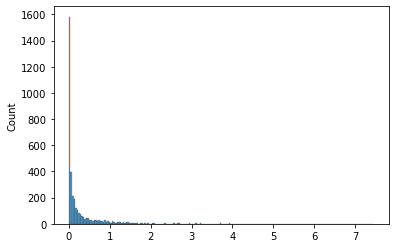

In [30]:
sns.histplot(scrClean)

# Model using hyperparameter in different way
- For reference:
https://docs.pymc.io/en/v3/pymc-examples/examples/case_studies/hierarchical_partial_pooling.html

In [17]:
with pm.Model() as m5:
    
    # α
    phi = pm.Uniform("phi", lower=0.0, upper=1.0)
    kappa_log = pm.Exponential("kappa_log", lam=1.5)
    kappa = pm.Deterministic("kappa", at.exp(kappa_log))
    alpha = pm.Beta("alpha", alpha=phi * kappa, beta=(1.0 - phi) * kappa, shape=n_subj)
    
    # β (reparametarization)
    beta_h = pm.Normal('beta_h', 0,1, shape=n_subj)
    beta_sd = pm.HalfNormal('beta_sd', 5)
    beta = pm.Deterministic('beta',0 + beta_h*beta_sd)
       
    eps = pm.HalfNormal('eps', 5)
    
    Qs = 0.5 * at.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec = 0.5 * at.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec, pe], updates = aesara.scan(
        fn=update_Q,
        sequences=[stim, shock],
        outputs_info=[Qs, vec, None],
        non_sequences=[alpha, n_subj])
   
     
    vec_ = vec[trials, subj,0] * beta[subj]
    # add matrix of expected values (trials X subjects)
    ev = pm.Deterministic('expected_value', vec_)
    # add PE
    pe = pm.Deterministic('pe', pe)
    
    # transform to vector
    v = at.reshape(vec_.T, n_subj*n_trials, ndim=1)
    # clean shocks
    vec_clean = v[shockVec==0]
       
    # likelihood function
    scrs = pm.Normal('scrs', mu = vec_clean, sigma = eps, observed=scrClean) 
   

In [19]:
with m5:
    trH_phi = pm.sample(target_accept=.95, chains=4,  draws = 5000)

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [phi, kappa_log, alpha, beta_h, beta_sd, eps]
INFO:pymc:NUTS: [phi, kappa_log, alpha, beta_h, beta_sd, eps]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 2944 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 2944 seconds.


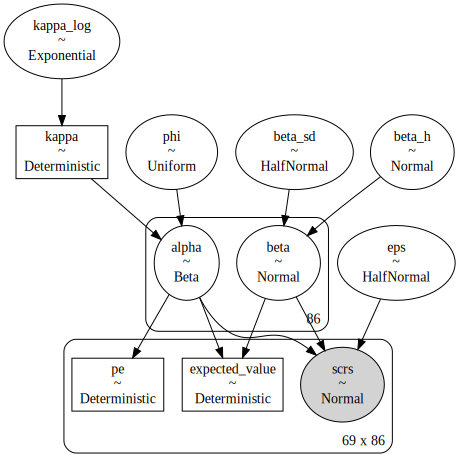

In [19]:
pm.model_to_graphviz(m5)

In [17]:
trH_phi.to_netcdf('trH_phi_noShocks.nc') # saving the trace
# loading
#trH_phi = az.from_netcdf("trH_phi.nc")

'trH_phi_noShocks.nc'

array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>]], dtype=object)

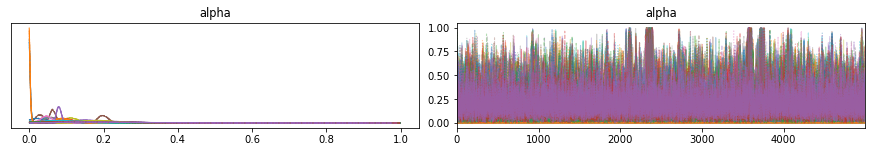

In [18]:
az.plot_trace(trH_phi, var_names='alpha')

In [19]:
az.summary(trH_phi, var_names='alpha')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.003,0.002,0.000,0.007,0.000,0.000,8085.0,6259.0,1.0
alpha[1],0.185,0.079,0.053,0.333,0.001,0.000,15396.0,12103.0,1.0
alpha[2],0.153,0.064,0.046,0.272,0.000,0.000,19550.0,13224.0,1.0
alpha[3],0.109,0.053,0.025,0.208,0.000,0.000,16680.0,12858.0,1.0
alpha[4],0.176,0.146,0.000,0.423,0.003,0.003,5137.0,2268.0,1.0
...,...,...,...,...,...,...,...,...,...
alpha[60],0.179,0.147,0.000,0.430,0.003,0.003,5402.0,2237.0,1.0
alpha[61],0.002,0.002,0.000,0.006,0.000,0.000,7993.0,5354.0,1.0
alpha[62],0.152,0.126,0.000,0.368,0.002,0.002,9878.0,4639.0,1.0
alpha[63],0.183,0.138,0.000,0.419,0.003,0.003,6586.0,2676.0,1.0


In [82]:
az.compare({'simpleModel':tr, 'hierarchy':trH_phi})

/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more r

ValueError: The number of observations should be the same across all models

### Same but with intercept

In [30]:
with pm.Model() as m5_intercept:
    
    # intercept
    mu = pm.Normal('mu', 0, 5)
    sd = pm.HalfNormal('sd',5) 
    intercept_matt = pm.Normal('intercept_matt', mu=0, sd=1, shape=n_subj)
    intercept = pm.Deterministic('intercept',mu + intercept_matt*sd)
    
    # \alpha
    phi = pm.Uniform("phi", lower=0.0, upper=1.0)
    kappa_log = pm.Exponential("kappa_log", lam=1.5)
    kappa = pm.Deterministic("kappa", tt.exp(kappa_log))
    alpha = pm.Beta("alpha", alpha=phi * kappa, beta=(1.0 - phi) * kappa, shape=n_subj)
    
    # β (reparametarization)
    beta_h = pm.Normal('beta_h', 0,1, shape=n_subj)
    beta_sd = pm.HalfNormal('beta_sd', 5)
    beta = pm.Deterministic('beta',0 + beta_h*beta_sd)
       
    eps = pm.HalfNormal('eps', 5)
    
    Qs = 0.5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec = 0.5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec, pe], updates = theano.scan(
        fn=update_Q,
        sequences=[stim, shock],
        outputs_info=[Qs, vec, None],
        non_sequences=[alpha, n_subj])
   
     
    vec_ = vec[trials, subj,0] * beta[subj] + intercept[subj]
    
    # transform to vector
    v = tt.reshape(vec_.T, n_subj*n_trials, ndim=1)
    # clean shocks
    vec_clean = v[shockVec==0]
       
    # likelihood function
    scrs = pm.Normal('scrs', mu = vec_clean, sd = eps, observed=scrClean) 
    
    trH_phi2 = pm.sample(target_accept=.95, chains=4, cores=10, return_inferencedata=True,
                        draws = 5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, beta_sd, beta_h, alpha, kappa_log, phi, intercept_matt, sd, mu]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 8298 seconds.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


In [34]:
# saving
trH_phi2.to_netcdf('trH_phi_intercept_noShocks.nc') # saving the trace

'trH_phi_intercept_noShocks.nc'

In [ ]:
az.summary(trH_phi2)

In [35]:
comp = az.compare({'model1': trH_phi, 'model2':trH_phi2}, ic='waic')
comp

/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/arviz/stats/stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/arviz/stats/stats.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale)])
/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/arviz/stats/stats.py:1

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
model2,0,-2235.143338,183.768053,0.000000,0.82686,185.008247,0.000000,True,log
model1,1,-2259.875565,146.610635,24.732226,0.17314,180.847988,10.173971,True,log


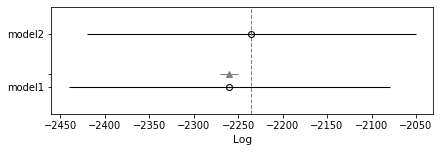

In [36]:
az.plot_compare(comp, insample_dev=False);

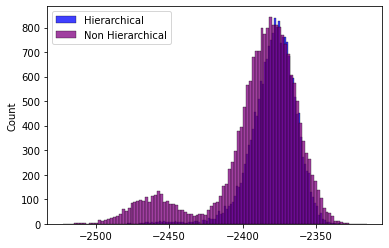

In [31]:
# calculate logP
# calculate logP
logP = trH_phi.sample_stats.lp.stack(draws=('chain','draw'))
logP1 = trH_phi2.sample_stats.lp.stack(draws=('chain','draw'))
sns.histplot(logP, label='Hierarchical', color='blue')
sns.histplot(logP1, label='Non Hierarchical', color='purple')
plt.legend()
#plt.vlines(np.mean(logP), 0, 250, color='red')

# Correlate with actual data

In [21]:
# grab alphas
alphas = trH_phi.posterior.stack(draws=('chain','draw'))
alphas = np.mean(alphas.alpha, axis=1)

alphas = pd.DataFrame({'subject': scrTwo['sub'].unique(), 'alphas':alphas })
alphas

,subject,alphas
0,sub-189,0.002609
1,sub-205,0.184995
2,sub-071,0.153141
3,sub-204,0.109353
4,sub-085,0.176157
...,...,...
60,sub-010,0.179446
61,sub-158,0.002370
62,sub-083,0.152149
63,sub-126,0.183158


In [22]:
# stack all chains
a = trH_phi.posterior.stack(draws=('chain','draw'))
a = a.expected_value
a.shape

(69, 65, 20000)

In [23]:
mean_a = np.mean(a, axis=2)
mean_a.shape

(69, 65)

In [24]:
# grab Prediction error
mean_pe = trH_phi.posterior.stack(draws=('chain','draw')).pe
mean_pe = np.mean(mean_pe, axis=2)


In [25]:
# calculate 
for i in np.arange(n_subj):
    cor1 = scipy.stats.pearsonr(scrMat[:,i], mean_a[:,i])
    print(cor1)

(-0.33196507227021943, 0.005325968439900554)
(0.6665858064212723, 4.0463901298786694e-10)
(0.5595001324272292, 5.804910774660625e-07)
(0.6271060838411354, 8.151666050064887e-09)
(0.3886217234504577, 0.0009672048911012346)
(0.5317895745583491, 2.5748217714560563e-06)
(0.4130646508684521, 0.00041964844617333347)
(0.31573577634377153, 0.008223417049061451)
(0.7311763739564323, 9.761851322599483e-13)
(0.626436666394091, 8.54647431015084e-09)
(0.2261134421532405, 0.06173407657608152)
(0.05795390045924833, 0.6362099779841711)
(0.4503505688994873, 0.0001032638857494796)
(0.5741649549486095, 2.4947277671119764e-07)
(0.5317826668524265, 2.5757360305777203e-06)
(0.6953796498249633, 3.349190307638337e-11)
(0.5056720496322373, 9.335684886543669e-06)
(0.5590117650825984, 5.966343163467964e-07)
(0.7246204020184215, 1.9435501728678356e-12)
(0.3226600915491454, 0.00685136183954492)
(0.5365733229529256, 2.0097890794524677e-06)
(0.48898844795343366, 2.0142028123436578e-05)
(0.8234026753006134, 3.8217606

In [26]:
# seems that some subjects are really problematic. 
# should consider removing them from analysis

mean_a_vec = np.reshape(mean_a.T, (69*n_subj,1)) # reshape to fit dataframe
mean_pe_vec = np.reshape(mean_pe.T, (69*n_subj,1)) # reshape PE

In [27]:
scrTwo['expected_value'] = mean_a_vec.values
scrTwo['pe'] = mean_pe_vec.values

/tmp/ipykernel_30729/1811389849.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scrTwo['expected_value'] = mean_a_vec.values
/tmp/ipykernel_30729/1811389849.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scrTwo['pe'] = mean_pe_vec.values


In [28]:
scrTwo['scr'] = scrTwo['CDA.AmpSum']

/tmp/ipykernel_30729/1130903711.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scrTwo['scr'] = scrTwo['CDA.AmpSum']


In [29]:
# save file
scrTwo.to_csv('scr_clean2.csv', index=False)

# Load brain data
Hippocampus - amygdala coupling

In [38]:
amg_hipp = pd.read_csv('dfSCR_coupling.csv')#('amg_hipp_fc_allTrials.csv')
amg_hipp

,index,subject,trialNo,condition,coupling,amg,Sub,group,Eprime,sub,Condition,Event.Nr,CDA.AmpSum,scr
0,0,sub-167,1,CSplusUS1,0.761905,-0.665134,sub-167,HC,A,sub-167,CSplusUS1,1,1.4637,1.4637
1,1,sub-167,2,CSminus1,-0.238095,-0.060757,sub-167,HC,A,sub-167,CSminus1,2,1.3764,1.3764
2,2,sub-167,3,CSplus1,0.095238,0.984678,sub-167,HC,A,sub-167,CSplus1,3,2.2023,2.2023
3,3,sub-167,4,CSplusUS1,0.523810,0.488085,sub-167,HC,A,sub-167,CSplusUS1,4,2.7164,2.7164
4,4,sub-167,5,CSminus1,-0.428571,0.053875,sub-167,HC,A,sub-167,CSminus1,5,2.3635,2.3635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4616,1720,sub-200,65,CSplus2,-0.023810,-0.128837,sub-200,HC,B,sub-200,CSplus2,65,0.0839,0.0839
4617,1721,sub-200,66,CSminus2,-0.500000,-0.126025,sub-200,HC,B,sub-200,CSminus2,66,0.9347,0.9347
4618,1722,sub-200,67,CSminus2,-0.119048,-0.097882,sub-200,HC,B,sub-200,CSminus2,67,0.5522,0.5522
4619,1723,sub-200,68,CSplus2,0.452381,0.117315,sub-200,HC,B,sub-200,CSplus2,68,0.0786,0.0786


In [39]:
vmpfc_amg = pd.read_csv('vmPFCcoupling.csv')
vmpfc_amg = vmpfc_amg.rename(columns={'coupling': 'amg_vmpfc'})
amg_hipp['amg_vmpfc'] = vmpfc_amg['amg_vmpfc'] # add this to amg hippocampus data

In [40]:
len(vmpfc_amg['amg_vmpfc'])

4621

In [41]:
sum(np.isnan(amg_hipp['amg_vmpfc']))

0

In [42]:
# add hippocampus anterior
hippAnt_amg = pd.read_csv('HippAntcoupling.csv')
hippAnt_amg = hippAnt_amg.rename(columns = {'coupling': 'amg_HippAnt'})
amg_hipp['amg_HippAnt'] = hippAnt_amg['amg_HippAnt']

In [43]:
# add control regions
ctrl_amg = pd.read_csv('controlROI.csv')
ctrl_amg = ctrl_amg.rename(columns = {'coupling': 'amg_ctrl'})
amg_hipp['amg_ctrl'] = ctrl_amg['amg_ctrl']

In [77]:
m_acc = pd.read_csv('mACC_coupling.csv')
m_acc = m_acc.rename(columns = {'coupling': 'amg_mACC'})

In [44]:
dfAll = pd.merge(scrTwo, amg_hipp)#, right_on=['subject','trialNo'], left_on=['sub','Event.Nr'])
dfAll.head()

,sub,Condition,Event.Nr,CDA.AmpSum,expected_value,pe,scr,index,subject,trialNo,condition,coupling,amg,Sub,group,Eprime,amg_vmpfc,amg_HippAnt,amg_ctrl
0,sub-189,CSplusUS1,1,0.2852,0.801175,0.500000,0.2852,1794,sub-189,1,CSplusUS1,0.309524,0.981121,sub-189,HC,A,0.904762,0.571429,0.523810
1,sub-189,CSminus1,2,0.1033,0.796939,-0.500000,0.1033,1795,sub-189,2,CSminus1,-0.571429,-0.027048,sub-189,HC,A,0.404762,-0.119048,0.404762
2,sub-189,CSplus1,3,0.0783,0.799047,-0.501304,0.0783,1796,sub-189,3,CSplus1,-0.476190,-0.045910,sub-189,HC,A,0.333333,-0.642857,0.119048
3,sub-189,CSplusUS1,4,0.1772,0.801165,0.500006,0.1772,1797,sub-189,4,CSplusUS1,0.166667,-0.674150,sub-189,HC,A,0.690476,0.357143,0.285714
4,sub-189,CSminus1,5,0.0000,0.794832,-0.498696,0.0000,1798,sub-189,5,CSminus1,0.214286,-0.065602,sub-189,HC,A,0.595238,0.309524,0.214286


In [45]:
sum(np.isnan(dfAll['amg_vmpfc']))

0

In [46]:
sum(np.isnan(dfAll['amg_ctrl']))

0

In [47]:
dfAll.to_csv('scr_amg_hipp_all.csv', index=False)

In [50]:
len(dfAll['sub'].unique())

65

In [48]:
# Statistical analysis
import statsmodels.api as sm
import statsmodels.formula.api as smf
glm = smf.mixedlm('expected_value ~ coupling+ C(Condition) + amg + trialNo', data=dfAll, 
    groups = 'subject', 
                 missing='drop')
model1 = glm.fit()
print(model1.summary())

                Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    expected_value
No. Observations:     4485       Method:                REML          
No. Groups:           65         Scale:                 0.0569        
Min. group size:      69         Log-Likelihood:        -148.0076     
Max. group size:      69         Converged:             Yes           
Mean group size:      69.0                                            
----------------------------------------------------------------------
                           Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                   0.380    0.060   6.365 0.000  0.263  0.497
C(Condition)[T.CSminus2]    0.167    0.017   9.850 0.000  0.134  0.200
C(Condition)[T.CSminusUS2]  0.223    0.018  12.714 0.000  0.189  0.258
C(Condition)[T.CSplus1]     0.167    0.012  13.822 0.000  0.144  0.191
C(Condition)[T.CSplus2]

In [49]:
# Statistical analysis
import statsmodels.api as sm
import statsmodels.formula.api as smf
glm = smf.mixedlm('expected_value ~ coupling+ C(Condition) + amg + trialNo', data=dfAll, 
    groups = 'subject', 
                 missing='drop')
model1 = glm.fit()
print(model1.summary())

                Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    expected_value
No. Observations:     4485       Method:                REML          
No. Groups:           65         Scale:                 0.0569        
Min. group size:      69         Log-Likelihood:        -148.0076     
Max. group size:      69         Converged:             Yes           
Mean group size:      69.0                                            
----------------------------------------------------------------------
                           Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                   0.380    0.060   6.365 0.000  0.263  0.497
C(Condition)[T.CSminus2]    0.167    0.017   9.850 0.000  0.134  0.200
C(Condition)[T.CSminusUS2]  0.223    0.018  12.714 0.000  0.189  0.258
C(Condition)[T.CSplus1]     0.167    0.012  13.822 0.000  0.144  0.191
C(Condition)[T.CSplus2]

In [50]:
# assessing prediction error
glm_1 = smf.mixedlm('pe ~ coupling +  amg + trialNo', data=dfAll, 
    groups = 'subject', 
                 missing='drop')
model1_1 = glm_1.fit()
print(model1_1.summary())

/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: pe        
No. Observations: 4485    Method:             REML      
No. Groups:       65      Scale:              0.1589    
Min. group size:  69      Log-Likelihood:     -2254.3617
Max. group size:  69      Converged:          Yes       
Mean group size:  69.0                                  
--------------------------------------------------------
             Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept    -0.164    0.012 -13.657 0.000 -0.188 -0.141
coupling      0.070    0.014   5.002 0.000  0.043  0.097
amg          -0.010    0.014  -0.734 0.463 -0.037  0.017
trialNo       0.001    0.000   4.629 0.000  0.001  0.002
subject Var   0.000    0.001                            



/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


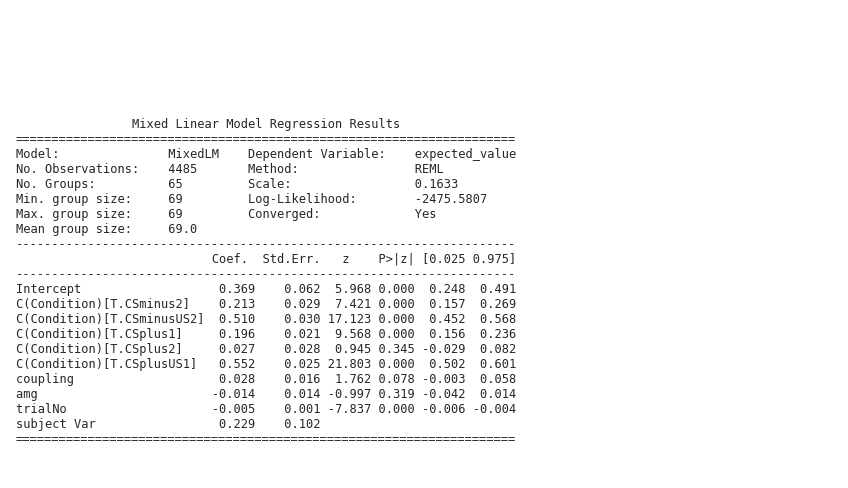

In [109]:
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model1.summary()), {'fontsize': 12}, fontproperties = 'monospace') 
plt.axis('off')
plt.tight_layout()
plt.savefig('outputEV_Coupling.png')

# Plotting results

(0.44207895950602594, 0.0001429445638346312)

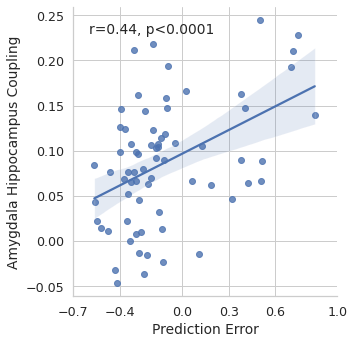

In [52]:
# plot results
forPlot = dfAll.groupby(['Event.Nr']).mean()
sns.set(font_scale = 1.15)
sns.set_style("whitegrid")
a = sns.lmplot(x ='pe', y='coupling', data= forPlot)
a.set_axis_labels("Prediction Error")
a.set_ylabels("Amygdala Hippocampus Coupling")
plt.text(-0.6,0.23, "r=0.44, p<0.0001")

a.set(xlim = (-0.7,0.95))
a.set(xticks=np.linspace(-0.7, 0.95, 6).round(1))
#a.savefig('pe_coupling.png', dpi=300, bbox_inches='tight')
scipy.stats.pearsonr(forPlot['pe'], forPlot['coupling'])


# Do the same with VMPFC

In [141]:
glmVM = smf.mixedlm('expected_value ~ amg_vmpfc+ C(Condition) + amg + trialNo', data=dfAll, 
    groups = 'subject', 
                 missing='drop')
modelVM = glmVM.fit()
print(modelVM.summary())

                Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    expected_value
No. Observations:     4485       Method:                REML          
No. Groups:           65         Scale:                 0.0557        
Min. group size:      69         Log-Likelihood:        -102.4209     
Max. group size:      69         Converged:             Yes           
Mean group size:      69.0                                            
----------------------------------------------------------------------
                           Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                   0.381    0.059   6.425 0.000  0.265  0.497
C(Condition)[T.CSminus2]    0.170    0.017  10.162 0.000  0.137  0.203
C(Condition)[T.CSminusUS2]  0.235    0.017  13.509 0.000  0.201  0.269
C(Condition)[T.CSplus1]     0.170    0.012  14.224 0.000  0.147  0.194
C(Condition)[T.CSplus2]

In [142]:
glmVM_pe = smf.mixedlm('pe ~ amg_vmpfc+ amg + trialNo', data=dfAll, 
    groups = 'subject', 
                 missing='drop')
modelVM_pe = glmVM_pe.fit()
print(modelVM_pe.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: pe        
No. Observations: 4485    Method:             REML      
No. Groups:       65      Scale:              0.1601    
Min. group size:  69      Log-Likelihood:     -2272.3676
Max. group size:  69      Converged:          Yes       
Mean group size:  69.0                                  
--------------------------------------------------------
             Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept    -0.152    0.014 -11.123 0.000 -0.178 -0.125
amg_vmpfc    -0.021    0.016  -1.308 0.191 -0.053  0.011
amg          -0.007    0.014  -0.481 0.631 -0.034  0.021
trialNo       0.002    0.000   4.999 0.000  0.001  0.002
subject Var   0.000    0.001                            



/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


(-0.22545513110744397, 0.06251617328812986)

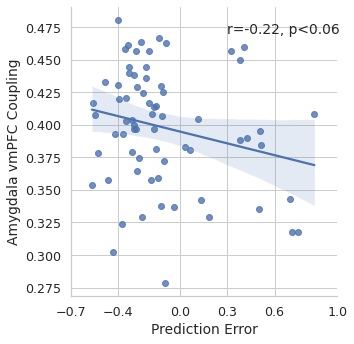

In [54]:
forPlot = dfAll.groupby(['Event.Nr']).mean()
sns.set(font_scale = 1.15)
sns.set_style("whitegrid")
a = sns.lmplot(x ='pe', y='amg_vmpfc', data= forPlot)
a.set_axis_labels("Prediction Error")
a.set_ylabels("Amygdala vmPFC Coupling")
plt.text(0.3,0.47, "r=-0.22, p<0.06")

a.set(xlim = (-0.7,0.95))
a.set(xticks=np.linspace(-0.7, 0.95, 6).round(1))
#a.savefig('pe_VMPFCcoupling.png', dpi=300, bbox_inches='tight')
scipy.stats.pearsonr(forPlot['pe'], forPlot['amg_vmpfc'])


# Now with Amygdala-Anterior hippocampus

In [55]:
glmAH = smf.mixedlm('expected_value ~ amg_HippAnt+ C(Condition) + amg + trialNo', data=dfAll, 
    groups = 'subject', 
                 missing='drop')
modelAH = glmAH.fit()
print(modelAH.summary())

                Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    expected_value
No. Observations:     4485       Method:                REML          
No. Groups:           65         Scale:                 0.0570        
Min. group size:      69         Log-Likelihood:        -150.8862     
Max. group size:      69         Converged:             Yes           
Mean group size:      69.0                                            
----------------------------------------------------------------------
                           Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                   0.379    0.060   6.364 0.000  0.263  0.496
C(Condition)[T.CSminus2]    0.166    0.017   9.775 0.000  0.132  0.199
C(Condition)[T.CSminusUS2]  0.224    0.018  12.733 0.000  0.190  0.259
C(Condition)[T.CSplus1]     0.167    0.012  13.774 0.000  0.143  0.190
C(Condition)[T.CSplus2]

In [56]:
glmAH_pe = smf.mixedlm('pe ~ amg_HippAnt+ amg + trialNo', data=dfAll, 
    groups = 'subject', 
                 missing='drop')
modelAH_pe = glmAH_pe.fit()
print(modelAH_pe.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: pe        
No. Observations: 4485    Method:             REML      
No. Groups:       65      Scale:              0.1593    
Min. group size:  69      Log-Likelihood:     -2260.6282
Max. group size:  69      Converged:          Yes       
Mean group size:  69.0                                  
--------------------------------------------------------
             Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept    -0.174    0.013 -13.902 0.000 -0.198 -0.149
amg_HippAnt   0.054    0.015   3.562 0.000  0.024  0.084
amg          -0.008    0.014  -0.552 0.581 -0.035  0.020
trialNo       0.001    0.000   4.770 0.000  0.001  0.002
subject Var   0.000    0.001                            



/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


(0.38798332275942493, 0.0009876991485325444)

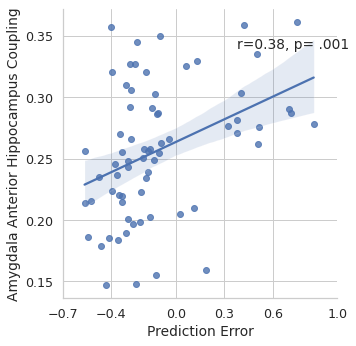

In [57]:
forPlot = dfAll.groupby(['Event.Nr']).mean()
sns.set(font_scale = 1.15)
sns.set_style("whitegrid")
a = sns.lmplot(x ='pe', y='amg_HippAnt', data= forPlot)
a.set_axis_labels("Prediction Error")
a.set_ylabels("Amygdala Anterior Hippocampus Coupling")
plt.text(0.38,0.34, "r=0.38, p= .001")

a.set(xlim = (-0.7,0.95))
a.set(xticks=np.linspace(-0.7, 0.95, 6).round(1))
#a.savefig('pe_AnteriorHippocampusCoupling.png', dpi=300, bbox_inches='tight')
scipy.stats.pearsonr(forPlot['pe'], forPlot['amg_HippAnt'])

# Summary:
- Amg-Hippocampus coupling is significantly predicting expected value!
- Amg - vmPFC is not

## Look at groups?

In [59]:
dfGroups = pd.read_csv('Behavioral/SubGroupLists.csv', dtype={'Sub': 'string'})
dfGroups = dfGroups[['Sub','group', 'Eprime']]
for i in dfGroups.iterrows():
    dfGroups.at[i[0], 'Sub'] = "sub-" + str(i[1].Sub)


,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,62,1.589356,0.212258,0.048769


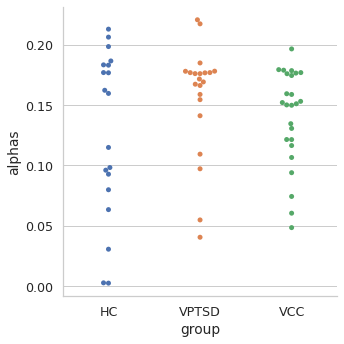

In [60]:
# test alphas and groups
alphas_b = pd.merge(alphas, dfGroups, left_on='subject', right_on='Sub')
sns.catplot(x='group',y='alphas', data=alphas_b, kind='swarm')
import pingouin as pg
pg.anova(data=alphas_b, between='group',dv='alphas')

In [61]:
alphas_b.to_csv('alphas_Reversal.csv', index=False)

In [62]:
alphas_b.groupby('group').describe()

alphas                                                              \
       count      mean       std       min       25%       50%       75%   
group                                                                      
HC      19.0  0.127779  0.069006  0.002370  0.086285  0.159727  0.183278   
VCC     25.0  0.140846  0.039780  0.048419  0.121430  0.151145  0.176067   
VPTSD   21.0  0.156837  0.045837  0.040433  0.154539  0.171670  0.176996   

                 
            max  
group            
HC     0.213034  
VCC    0.196630  
VPTSD  0.220806

In [64]:
pg.ttest(alphas_b['alphas'][alphas_b['group']=='HC'], alphas_b['alphas'][alphas_b['group']=='VPTSD'])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.551701,30.819605,two-sided,0.130943,"[-0.07, 0.01]",0.501185,0.794,0.338566


In [65]:
dfAll = pd.merge(dfAll, dfGroups, left_on='subject',right_on='Sub')
dfAll.head()

,sub,Condition,Event.Nr,CDA.AmpSum,expected_value,pe,scr,index,subject,trialNo,...,amg,Sub_x,group_x,Eprime_x,amg_vmpfc,amg_HippAnt,amg_ctrl,Sub_y,group_y,Eprime_y
0,sub-189,CSplusUS1,1,0.2852,0.801175,0.500000,0.2852,1794,sub-189,1,...,0.981121,sub-189,HC,A,0.904762,0.571429,0.523810,sub-189,HC,A
1,sub-189,CSminus1,2,0.1033,0.796939,-0.500000,0.1033,1795,sub-189,2,...,-0.027048,sub-189,HC,A,0.404762,-0.119048,0.404762,sub-189,HC,A
2,sub-189,CSplus1,3,0.0783,0.799047,-0.501304,0.0783,1796,sub-189,3,...,-0.045910,sub-189,HC,A,0.333333,-0.642857,0.119048,sub-189,HC,A
3,sub-189,CSplusUS1,4,0.1772,0.801165,0.500006,0.1772,1797,sub-189,4,...,-0.674150,sub-189,HC,A,0.690476,0.357143,0.285714,sub-189,HC,A
4,sub-189,CSminus1,5,0.0000,0.794832,-0.498696,0.0000,1798,sub-189,5,...,-0.065602,sub-189,HC,A,0.595238,0.309524,0.214286,sub-189,HC,A


In [ ]:
dfAll.to_csv('')

In [67]:
# Statistical analysis
import statsmodels.api as sm
import statsmodels.formula.api as smf
glm2 = smf.mixedlm('expected_value ~ coupling*C(group_x) + C(condition) + amg + trialNo', data=dfAll, 
    groups = 'subject', 
                 missing='drop')
model2 = glm2.fit()
print(model2.summary())

                 Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     expected_value
No. Observations:     4485        Method:                 REML          
No. Groups:           65          Scale:                  0.0568        
Min. group size:      69          Log-Likelihood:         -144.8244     
Max. group size:      69          Converged:              Yes           
Mean group size:      69.0                                              
------------------------------------------------------------------------
                             Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                     0.711    0.099   7.200 0.000  0.518  0.905
C(group_x)[T.VCC]            -0.442    0.130  -3.391 0.001 -0.698 -0.187
C(group_x)[T.VPTSD]          -0.501    0.136  -3.693 0.000 -0.767 -0.235
C(condition)[T.CSminus2]      0.166    0.017   9.816 0.000  0.133  0.

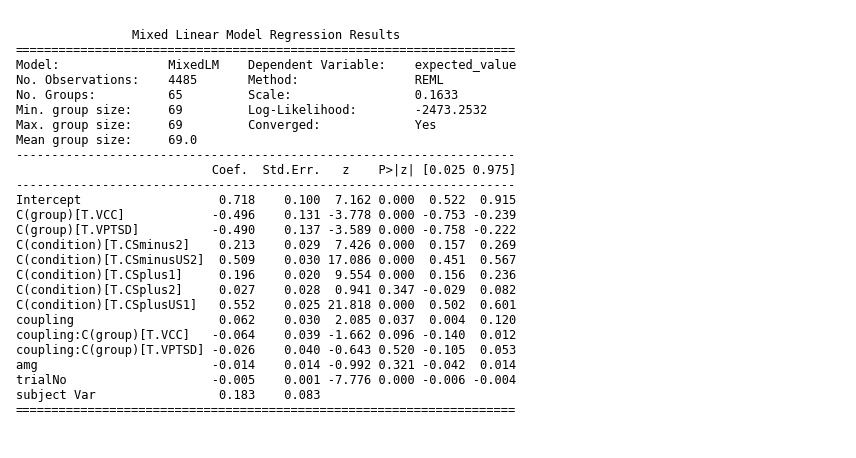

In [39]:
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model2.summary()), {'fontsize': 12}, fontproperties = 'monospace') 
plt.axis('off')
plt.tight_layout()
plt.savefig('outputEV_Coupling_groups.png')

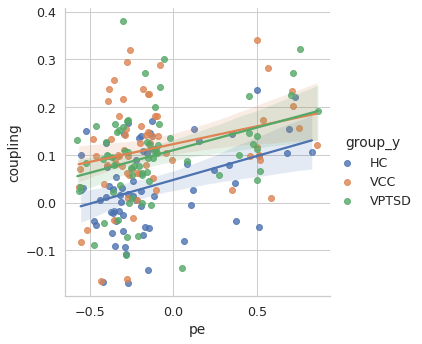

In [72]:
# using aggregate to summarize across groups
# this link is a nice reference: https://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/
dd = dfAll.groupby(['group_y', 'Event.Nr'], as_index=False).agg({'pe': 'mean', 'coupling':'mean'})

# plot
sns.lmplot(x='pe', y='coupling', hue='group_y', data=dd)

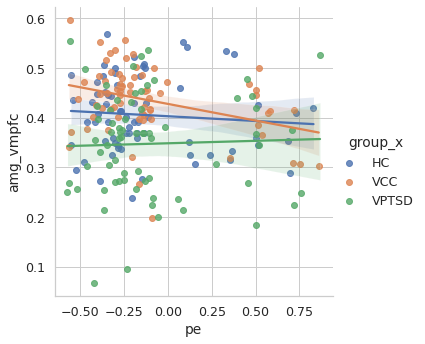

In [73]:
dd = dfAll.groupby(['group_x', 'Event.Nr'], as_index=False).agg({'pe': 'mean', 'amg_vmpfc':'mean'})
sns.lmplot(x='pe', y='amg_vmpfc', hue='group_x', data=dd)

In [77]:
glm3 = smf.mixedlm('pe ~ amg_vmpfc*C(group_x)+ amg + trialNo', data=dfAll, 
    groups = 'subject', 
                 missing='drop')
model3 = glm3.fit()
print(model3.summary())

                 Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      pe        
No. Observations:       4485         Method:                  REML      
No. Groups:             65           Scale:                   0.1596    
Min. group size:        69           Log-Likelihood:          -2273.8879
Max. group size:        69           Converged:               Yes       
Mean group size:        69.0                                            
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                     -0.175    0.020 -8.833 0.000 -0.213 -0.136
C(group_x)[T.VCC]              0.047    0.023  2.060 0.039  0.002  0.092
C(group_x)[T.VPTSD]            0.015    0.022  0.661 0.509 -0.029  0.058
amg_vmpfc                     -0.001    0.032 -0.026 0.979 -0.064  0.

/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [78]:
pg.mixed_anova(data=dfAll, dv = 'pe', between = 'group_x', subject='subject', within='amg_vmpfc')

ValueError: cannot convert float NaN to integer

# Implement mixed level model with pymc3

In [74]:
dfAll['subject'] = dfAll.subject.astype('category')
subIDX = dfAll.subject.cat.codes.values

In [61]:
subIDX

array([57, 57, 57, ..., 36, 36, 36], dtype=int8)

In [75]:
with pm.Model() as m:
    
    # linear mixed effects
    b = pm.Normal('b', 0,1, shape=n_subj) # intercept
    b2 = pm.Normal('b2', 0,1, shape=3) # effect of coupling[0], trialNo[1] and amygdala[2]
    sigma = pm.HalfNormal('sigms', 5)
  
  
    y = pm.Normal('y', b[subIDX] + b2[0]*dfAll.coupling + b2[1]*dfAll.trialNo + b2[2]*dfAll.amg,sigma,
                  observed=dfAll.pe)
    
    tr = pm.sample(target_accept=.9, chains=4, cores=10, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [sigms, b2, b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.


In [76]:
az.summary(tr, var_names='b2')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b2[0],0.083,0.015,0.054,0.111,0.0,0.0,4605.0,2937.0,1.0
b2[1],0.001,0.000,0.001,0.002,0.0,0.0,1733.0,2511.0,1.0
b2[2],-0.011,0.014,-0.036,0.015,0.0,0.0,5324.0,3190.0,1.0


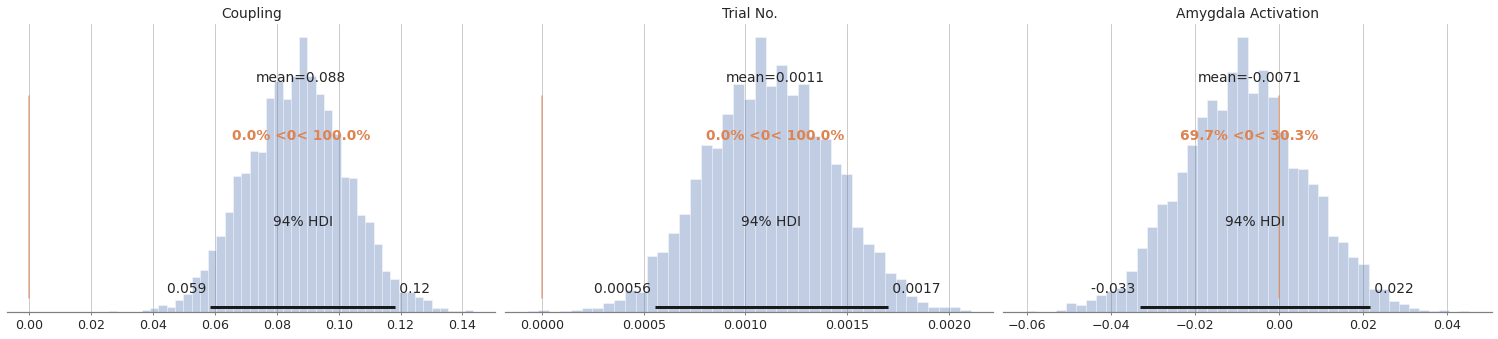

In [118]:
g = az.plot_posterior(tr, var_names='b2', kind='hist', ref_val=0)
g[0].title.set_text("Coupling")
g[1].title.set_text("Trial No.")
g[2].title.set_text("Amygdala Activation")

# Summary
- Coupling predicting changes

In [38]:
with m:
    ppc = pm.sample_posterior_predictive(tr)

In [ ]:
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=m), var_names='scrs')

### Posterior predictive for the m5 model

In [20]:
with m5:
    ppc = pm.sample_posterior_predictive(trH_phi)

<AxesSubplot:xlabel='scrs / scrs'>

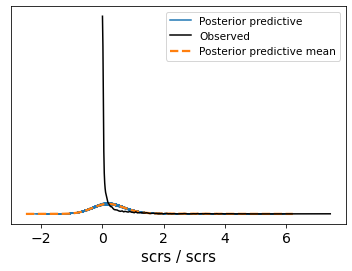

In [24]:
az.plot_ppc(ppc)

<AxesSubplot:ylabel='Count'>

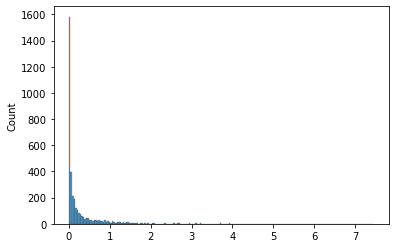

In [29]:
sns.histplot(trH_phi.observed_data.scrs.values)

In [23]:
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=m5))#, var_names='scrs')

AttributeError: 'Dataset' object has no attribute 'shape'